In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Path to your LAS file
file_path = './422393367200_WRA-1009_CXD_SEMB.las'

# Lists to hold the depth and log data (multiple logs)
depths = []
log_data = []

# Reading the LAS file manually
data_section = False  # To identify the start of the data section
with open(file_path, 'r') as las_file:
    for line in las_file:
        line = line.strip()  # Remove any leading/trailing whitespace

        # Look for the start of the data section (~A is the standard in LAS files)
        if line.startswith("~A"):
            data_section = True
            continue  # Skip the "~A" line itself

        # If we're in the data section, process the data
        if data_section:
            # Split the data line into components (assuming space-separated values)
            parts = line.split()
            if len(parts) >= 2:  # Ensure there are enough columns
                try:
                    # Convert the first column to depth and the rest to log data
                    depth = float(parts[0])
                    logs = [float(value) for value in parts[1:]]  # Store remaining columns as logs
                    # Only add valid data (exclude -9999 values)
                    if depth != -9999 and all(val != -9999 for val in logs):
                        depths.append(depth)
                        log_data.append(logs)
                except ValueError:
                    # Handle any lines that don't contain valid data
                    continue

# Convert to numpy arrays
depths = np.array(depths, dtype="float32")
# Convert depth from feet to meters (1 foot = 0.3048 meters)
depths = depths * 0.3048
log_data = np.array(log_data, dtype="float32")

# Define the formation tops in meters
formations = [
    {"name": "Glasscock", "top": 5465.68 * 0.3048},
    {"name": "Glasscock Base", "top": 5521.79 * 0.3048}
]

# Define rock matrix parameters for Gassmann's equations
rho_matrix = 2600  # Matrix density (kg/m³)

# Define fluid properties
rho_oil = 676  # Density of oil (kg/m³)
rho_CO2 = 478.3  # Density of CO2 (kg/m³)

K_oil = 0.3758e9  # Bulk modulus of oil (Pa)
K_CO2 = 0.02853e9  # Bulk modulus of CO2 (Pa)

# Compute effective fluid properties for 50% CO2 injection
rho_fluid_mixture = 0.5 * rho_CO2 + 0.5 * rho_oil
K_fluid_mixture = 1 / (0.5 / K_CO2 + 0.5 / K_oil)

# Dry rock properties (calculated)
log_DTC = log_data[:, 5]  # Compressional slowness (μs/ft)
log_DTSX = log_data[:, 7]  # Shear slowness (μs/ft)
log_DEN = log_data[:, 3]  # Density log (g/cc)

# Convert slowness to velocity (m/s)
Vp = 304800 / log_DTC  # Convert DTC to P-wave velocity (m/s)
Vs = 304800 / log_DTSX  # Convert DTSX to S-wave velocity (m/s)

# Convert density from g/cc to kg/m³
rho = log_DEN * 1000  # Convert density to kg/m³

# Compute Shear Modulus (G_dry)
G_dry = rho * Vs**2  # Shear modulus (Pa)

# Compute Bulk Modulus (K_dry) for dry rock
K_dry = rho * (Vp**2 - (4/3) * Vs**2)  # Bulk modulus (Pa)

# Matrix and fluid densities for porosity calculation
rho_matrix_sh = 2550  # Matrix density of shale (g/cm³)
rho_fluid = rho_oil  # Assuming the formation contains oil
bulk_density = log_DEN * 1000  # Bulk density log (kg/m³)

# Calculate porosity from density
porosity_density = (rho_matrix - bulk_density) / (rho_matrix - rho_fluid)

# Shale porosity
rho_bulk_shale = 2240  # Example density log data for shale region
phi_shale = (rho_matrix_sh - rho_bulk_shale) / (rho_matrix_sh - rho_fluid)

# Effective porosity
log_GRGC = log_data[:, 11]  # Gamma Ray log (log_GRGC)
GR_min = 55.91680145263672  # Gamma Ray value for clean sandstone
GR_max = 126.69599914550781  # Gamma Ray value for pure shale
I_GR = (log_GRGC - GR_min) / (GR_max - GR_min)  # Gamma Ray Index
Vsh = 0.083 * (2**(3.7 * I_GR) - 1)  # Volume of shale (Vsh)
Vsh = np.clip(Vsh, 0, 1)
porosity_eff = porosity_density - Vsh * phi_shale

# Reservoir top and bottom in meters
formation_top = formations[0]['top']
formation_bottom = formations[1]['top']

# Filter data within the injection zone
injection_zone_mask = (depths >= formation_top) & (depths <= formation_bottom)
depth_injection = depths[injection_zone_mask]
porosity_injection = porosity_eff[injection_zone_mask]
density_injection = rho[injection_zone_mask]

# Compute baseline bulk density (pre-CO2 injection)
rho_baseline = (1 - porosity_injection) * rho_matrix + porosity_injection * rho_oil

# Compute bulk density after 50% CO2 injection
rho_monitor = (1 - porosity_injection) * rho_matrix + porosity_injection * rho_fluid_mixture

# Gassmann's fluid substitution equation
def gassmann(K_dry, K_matrix, K_fluid, porosity):
    numerator = (1 - K_dry / K_matrix)**2
    denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
    K_sat = K_dry + numerator / denominator
    return K_sat

# Create a range of K_matrix values to vary (you can modify these values as needed)
K_matrix_values = np.linspace(15e9, 35e9, num=100)  # Vary K_matrix between 30 and 40 GPa

# Repeat depth and K_matrix arrays to create a meshgrid for 3D plotting
K_matrix_mesh, depth_mesh = np.meshgrid(K_matrix_values, depth_injection)

# Recompute Vp_baseline and Vp_monitor for each K_matrix in the range
Vp_baseline_3D = np.zeros_like(K_matrix_mesh)
Vp_monitor_3D = np.zeros_like(K_matrix_mesh)

for i in range(K_matrix_values.shape[0]):
    # Pass the current K_matrix value to the Gassmann function
    K_baseline_temp = gassmann(K_dry[injection_zone_mask], K_matrix_values[i], K_oil, porosity_injection)
    K_monitor_temp = gassmann(K_dry[injection_zone_mask], K_matrix_values[i], K_fluid_mixture, porosity_injection)
    
    # Compute Vp for both baseline and monitoring with the varying K_matrix
    Vp_baseline_3D[:, i] = np.sqrt((K_baseline_temp + (4 / 3) * G_dry[injection_zone_mask]) / rho_baseline)
    Vp_monitor_3D[:, i] = np.sqrt((K_monitor_temp + (4 / 3) * G_dry[injection_zone_mask]) / rho_monitor)




    
    
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Baseline plot
# fig_baseline = plt.figure(figsize=(12, 8))
# ax_baseline = fig_baseline.add_subplot(111, projection='3d')

# # Plot Vp_baseline in 3D
# surf_baseline = ax_baseline.plot_surface(K_matrix_mesh, depth_mesh, Vp_baseline_3D, cmap='viridis', alpha=0.9, label='Baseline Vp')

# # Set labels and title for baseline
# ax_baseline.set_xlabel('K_matrix (Pa)')
# ax_baseline.set_ylabel('Depth (m)')
# ax_baseline.set_zlabel('P-wave Velocity (m/s)')
# ax_baseline.set_title('3D Plot of Baseline Vp vs Depth and K_matrix')

# # Invert the y-axis to show depth correctly
# ax_baseline.invert_yaxis()

# # Set axis limits for better visibility
# ax_baseline.set_xlim(K_matrix_values.min(), K_matrix_values.max())
# ax_baseline.set_ylim(depth_injection.min(), depth_injection.max())
# ax_baseline.set_zlim(Vp_baseline_3D.min(), Vp_baseline_3D.max())

# # Add colorbar for baseline surface
# fig_baseline.colorbar(surf_baseline, ax=ax_baseline, shrink=0.5, aspect=5, label='Baseline Vp (m/s)')

# # Show baseline plot
# plt.show()


# # Monitoring plot
# fig_monitor = plt.figure(figsize=(12, 8))
# ax_monitor = fig_monitor.add_subplot(111, projection='3d')

# # Plot Vp_monitor in 3D
# surf_monitor = ax_monitor.plot_surface(K_matrix_mesh, depth_mesh, Vp_monitor_3D, cmap='plasma', alpha=0.9, label='Monitor Vp')

# # Set labels and title for monitor
# ax_monitor.set_xlabel('K_matrix (Pa)')
# ax_monitor.set_ylabel('Depth (m)')
# ax_monitor.set_zlabel('P-wave Velocity (m/s)')
# ax_monitor.set_title('3D Plot of Monitoring Vp vs Depth and K_matrix')

# # Invert the y-axis to show depth correctly
# ax_monitor.invert_yaxis()

# # Set axis limits for better visibility
# ax_monitor.set_xlim(K_matrix_values.min(), K_matrix_values.max())
# ax_monitor.set_ylim(depth_injection.min(), depth_injection.max())
# ax_monitor.set_zlim(Vp_monitor_3D.min(), Vp_monitor_3D.max())

# # Add colorbar for monitor surface
# fig_monitor.colorbar(surf_monitor, ax=ax_monitor, shrink=0.5, aspect=5, label='Monitor Vp (m/s)')

# # Show monitor plot
# plt.show()


In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Gassmann's fluid substitution equation
# def gassmann(K_dry, K_matrix, K_fluid, porosity):
#     numerator = (1 - K_dry / K_matrix)**2
#     denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
#     K_sat = K_dry + numerator / denominator
#     return K_sat

# # Fixed value for K_matrix (e.g., 35 GPa)
# K_matrix = 35e9  # Fix K_matrix at 35 GPa

# # Create a range of rho_matrix values to vary (e.g., from 2400 to 2700 kg/m³)
# rho_matrix_values = np.linspace(2400, 2700, num=100)  # Vary rho_matrix between 2400 and 2700 kg/m³

# # Repeat depth and rho_matrix arrays to create a meshgrid for 3D plotting
# rho_matrix_mesh, depth_mesh = np.meshgrid(rho_matrix_values, depth_injection)

# # Recompute Vp_baseline and Vp_monitor for each rho_matrix in the range
# Vp_baseline_3D = np.zeros_like(rho_matrix_mesh)
# Vp_monitor_3D = np.zeros_like(rho_matrix_mesh)

# for i in range(rho_matrix_values.shape[0]):
#     # Recompute densities for baseline and monitor scenarios
#     rho_baseline = (1 - porosity_injection) * rho_matrix_values[i] + porosity_injection * rho_oil
#     rho_monitor = (1 - porosity_injection) * rho_matrix_values[i] + porosity_injection * rho_fluid_mixture

#     # Apply the fixed K_matrix value to the Gassmann function
#     K_baseline_temp = gassmann(K_dry[injection_zone_mask], K_matrix, K_oil, porosity_injection)
#     K_monitor_temp = gassmann(K_dry[injection_zone_mask], K_matrix, K_fluid_mixture, porosity_injection)

#     # Compute Vp for both baseline and monitoring with the varying rho_matrix
#     Vp_baseline_3D[:, i] = np.sqrt((K_baseline_temp + (4 / 3) * G_dry[injection_zone_mask]) / rho_baseline)
#     Vp_monitor_3D[:, i] = np.sqrt((K_monitor_temp + (4 / 3) * G_dry[injection_zone_mask]) / rho_monitor)

# # Plot Baseline
# fig_baseline = plt.figure(figsize=(12, 8))
# ax_baseline = fig_baseline.add_subplot(111, projection='3d')
# surf_baseline = ax_baseline.plot_surface(rho_matrix_mesh, depth_mesh, Vp_baseline_3D, cmap='viridis', alpha=0.9)

# ax_baseline.set_xlabel('rho_matrix (kg/m³)')
# ax_baseline.set_ylabel('Depth (m)')
# ax_baseline.set_zlabel('P-wave Velocity (m/s)')
# ax_baseline.set_title('3D Plot of Baseline Vp vs Depth and rho_matrix')
# ax_baseline.invert_yaxis()
# ax_baseline.set_xlim(rho_matrix_values.min(), rho_matrix_values.max())
# ax_baseline.set_ylim(depth_injection.min(), depth_injection.max())
# ax_baseline.set_zlim(Vp_baseline_3D.min(), Vp_baseline_3D.max())
# fig_baseline.colorbar(surf_baseline, ax=ax_baseline, shrink=0.5, aspect=5, label='Baseline Vp (m/s)')

# plt.show()

# # Plot Monitor
# fig_monitor = plt.figure(figsize=(12, 8))
# ax_monitor = fig_monitor.add_subplot(111, projection='3d')
# surf_monitor = ax_monitor.plot_surface(rho_matrix_mesh, depth_mesh, Vp_monitor_3D, cmap='plasma', alpha=0.9)

# ax_monitor.set_xlabel('rho_matrix (kg/m³)')
# ax_monitor.set_ylabel('Depth (m)')
# ax_monitor.set_zlabel('P-wave Velocity (m/s)')
# ax_monitor.set_title('3D Plot of Monitoring Vp vs Depth and rho_matrix')
# ax_monitor.invert_yaxis()
# ax_monitor.set_xlim(rho_matrix_values.min(), rho_matrix_values.max())
# ax_monitor.set_ylim(depth_injection.min(), depth_injection.max())
# ax_monitor.set_zlim(Vp_monitor_3D.min(), Vp_monitor_3D.max())
# fig_monitor.colorbar(surf_monitor, ax=ax_monitor, shrink=0.5, aspect=5, label='Monitor Vp (m/s)')

# plt.show()


Specified Depth: 1675 meters, Closest Depth: 1675.03 meters at Index: 35


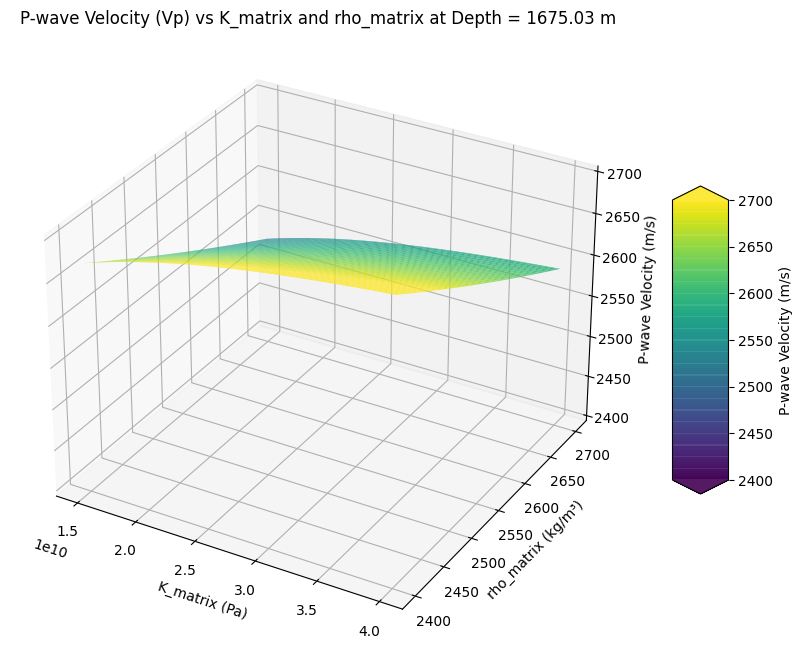

Specified Depth: 1681 meters, Closest Depth: 1681.12 meters at Index: 60


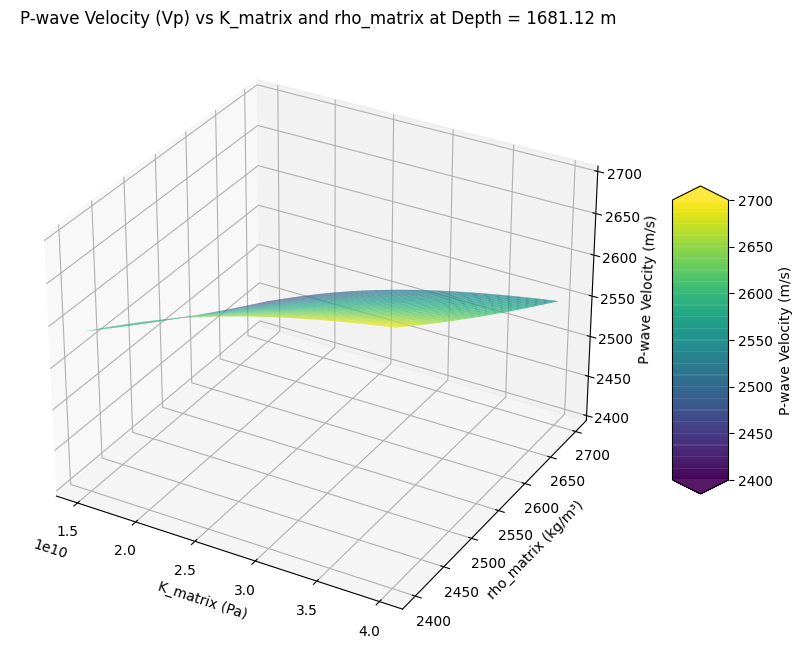

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gassmann's fluid substitution equation
def gassmann(K_dry, K_matrix, K_fluid, porosity):
    numerator = (1 - K_dry / K_matrix)**2
    denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
    K_sat = K_dry + numerator / denominator
    return K_sat

# Set the fixed range for P-wave Velocity (Vp)
vp_min = 2400  # Set the minimum value for Vp
vp_max = 2700  # Set the maximum value for Vp

# Function to plot Vp for a given depth
def plot_vp_at_depth(specified_depth):
    # Find the index of the closest depth value in the depth_injection array
    index = np.abs(depth_injection - specified_depth).argmin()
    actual_depth = depth_injection[index]

    print(f"Specified Depth: {specified_depth} meters, Closest Depth: {actual_depth:.2f} meters at Index: {index}")

    # Create a range of K_matrix values (e.g., from 15 to 40 GPa)
    K_matrix_values = np.linspace(15e9, 40e9, num=100)

    # Create a range of rho_matrix values (e.g., from 2400 to 2700 kg/m³)
    rho_matrix_values = np.linspace(2400, 2700, num=100)

    # Create a meshgrid for K_matrix and rho_matrix
    K_matrix_mesh, rho_matrix_mesh = np.meshgrid(K_matrix_values, rho_matrix_values)

    # Recompute Vp_baseline for each combination of K_matrix and rho_matrix
    Vp_3D = np.zeros_like(K_matrix_mesh)

    # Get the values at the closest depth index
    porosity_at_fixed_depth = porosity_injection[index]
    K_dry_at_fixed_depth = K_dry[injection_zone_mask][index]
    G_dry_at_fixed_depth = G_dry[injection_zone_mask][index]

    for i in range(K_matrix_values.shape[0]):
        for j in range(rho_matrix_values.shape[0]):
            # Compute baseline density
            rho_baseline = (1 - porosity_at_fixed_depth) * rho_matrix_values[j] + porosity_at_fixed_depth * rho_oil

            # Apply the Gassmann function at the closest depth
            K_baseline_temp = gassmann(K_dry_at_fixed_depth, K_matrix_values[i], K_oil, porosity_at_fixed_depth)

            # Compute Vp for the fixed depth, K_matrix, and rho_matrix
            Vp_3D[j, i] = np.sqrt((K_baseline_temp + (4 / 3) * G_dry_at_fixed_depth) / rho_baseline)

    # Plot the result
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Vp as a function of K_matrix and rho_matrix with fixed color range
    surf = ax.plot_surface(K_matrix_mesh, rho_matrix_mesh, Vp_3D, cmap='viridis', alpha=0.9, vmin=vp_min, vmax=vp_max)

    # Set labels and title
    ax.set_xlabel('K_matrix (Pa)')
    ax.set_ylabel('rho_matrix (kg/m³)')
    ax.set_zlabel('P-wave Velocity (m/s)')
    ax.set_title(f'P-wave Velocity (Vp) vs K_matrix and rho_matrix at Depth = {actual_depth:.2f} m')

    # Add colorbar with the same range as the z-axis (Vp)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='P-wave Velocity (m/s)', extend='both')

    # Set the range for P-wave Velocity (Vp) on the z-axis
    ax.set_zlim(vp_min, vp_max)

    # Show the plot
    plt.show()

# Example: Plot for two different depths to compare
plot_vp_at_depth(1675)  # First depth
plot_vp_at_depth(1681)  # Second depth


Specified Depth: 1675 meters, Closest Depth: 1675.03 meters at Index: 35
Specified Depth: 1682.5 meters, Closest Depth: 1682.50 meters at Index: 67


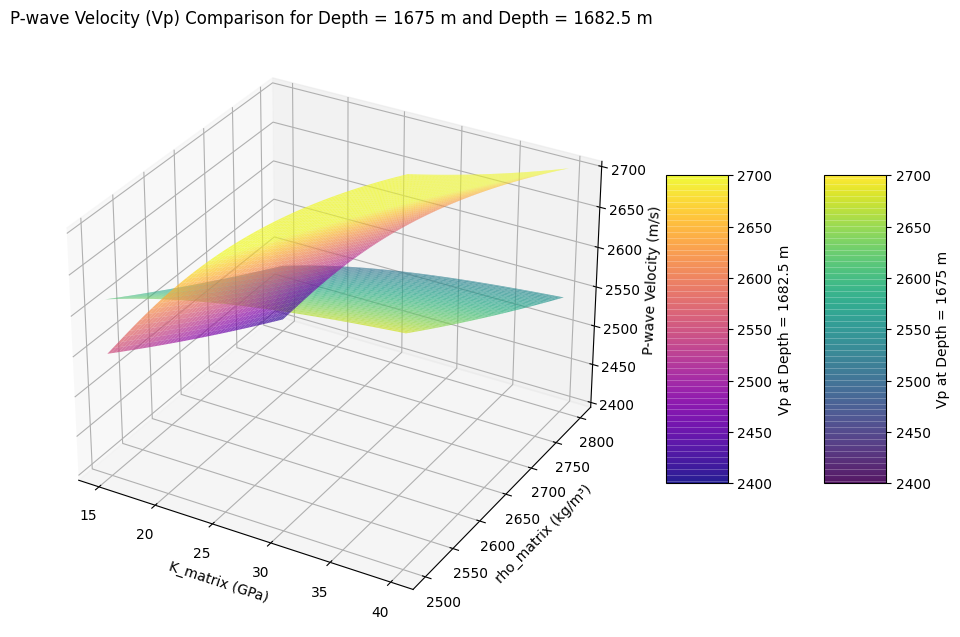

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gassmann's fluid substitution equation
def gassmann(K_dry, K_matrix, K_fluid, porosity):
    numerator = (1 - K_dry / K_matrix)**2
    denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
    K_sat = K_dry + numerator / denominator
    return K_sat

# Set the fixed range for P-wave Velocity (Vp)
vp_min = 2400  # Set the minimum value for Vp
vp_max = 2700  # Set the maximum value for Vp

# Function to compute Vp for a given depth
def compute_vp_at_depth(specified_depth):
    # Find the index of the closest depth value in the depth_injection array
    index = np.abs(depth_injection - specified_depth).argmin()
    actual_depth = depth_injection[index]

    print(f"Specified Depth: {specified_depth} meters, Closest Depth: {actual_depth:.2f} meters at Index: {index}")

    # Create a range of K_matrix values (e.g., from 15 to 40 GPa)
    K_matrix_values = np.linspace(15, 40, num=100)  # K_matrix now in GPa (no need for 10^9 factor)

    # Create a range of rho_matrix values (e.g., from 2400 to 2700 kg/m³)
    rho_matrix_values = np.linspace(2500, 2800, num=100)

    # Create a meshgrid for K_matrix and rho_matrix
    K_matrix_mesh, rho_matrix_mesh = np.meshgrid(K_matrix_values, rho_matrix_values)

    # Recompute Vp_baseline for each combination of K_matrix and rho_matrix
    Vp_3D = np.zeros_like(K_matrix_mesh)

    # Get the values at the closest depth index
    porosity_at_fixed_depth = porosity_injection[index]
    K_dry_at_fixed_depth = K_dry[injection_zone_mask][index]
    G_dry_at_fixed_depth = G_dry[injection_zone_mask][index]

    for i in range(K_matrix_values.shape[0]):
        for j in range(rho_matrix_values.shape[0]):
            # Convert K_matrix back to Pa for calculation (multiply by 1e9)
            K_matrix_pa = K_matrix_values[i] * 1e9

            # Compute baseline density
            rho_baseline = (1 - porosity_at_fixed_depth) * rho_matrix_values[j] + porosity_at_fixed_depth * rho_oil

            # Apply the Gassmann function at the closest depth
            K_baseline_temp = gassmann(K_dry_at_fixed_depth, K_matrix_pa, K_oil, porosity_at_fixed_depth)

            # Compute Vp for the fixed depth, K_matrix, and rho_matrix
            Vp_3D[j, i] = np.sqrt((K_baseline_temp + (4 / 3) * G_dry_at_fixed_depth) / rho_baseline)

    return K_matrix_mesh, rho_matrix_mesh, Vp_3D

# Plot the merged results for two different depths
def plot_merged_vp_for_two_depths(depth1, depth2):
    # Compute Vp for both depths
    K_matrix_mesh_1, rho_matrix_mesh_1, Vp_3D_1 = compute_vp_at_depth(depth1)
    K_matrix_mesh_2, rho_matrix_mesh_2, Vp_3D_2 = compute_vp_at_depth(depth2)

    # Plot the result
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Vp for depth1 using a different color map
    surf1 = ax.plot_surface(K_matrix_mesh_1, rho_matrix_mesh_1, Vp_3D_1, cmap='viridis', alpha=0.7, vmin=vp_min, vmax=vp_max)
    
    # Plot Vp for depth2 using a different color map
    surf2 = ax.plot_surface(K_matrix_mesh_2, rho_matrix_mesh_2, Vp_3D_2, cmap='plasma', alpha=0.7, vmin=vp_min, vmax=vp_max)

    # Set labels and title
    ax.set_xlabel('K_matrix (GPa)')  # Change the unit to GPa
    ax.set_ylabel('rho_matrix (kg/m³)')
    ax.set_zlabel('P-wave Velocity (m/s)')
    ax.set_title(f'P-wave Velocity (Vp) Comparison for Depth = {depth1} m and Depth = {depth2} m')

    # Add colorbars for both surfaces with same range
    fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5, label=f'Vp at Depth = {depth1} m')
    fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=5, label=f'Vp at Depth = {depth2} m')

    # Set the range for P-wave Velocity (Vp) on the z-axis
    ax.set_zlim(vp_min, vp_max)

    # Show the plot
    plt.show()

# Example: Plot the merged result for two different depths
plot_merged_vp_for_two_depths(1675, 1682.5)


Specified Depth: 1675 meters, Closest Depth: 1675.03 meters at Index: 35
Specified Depth: 1681 meters, Closest Depth: 1681.12 meters at Index: 60


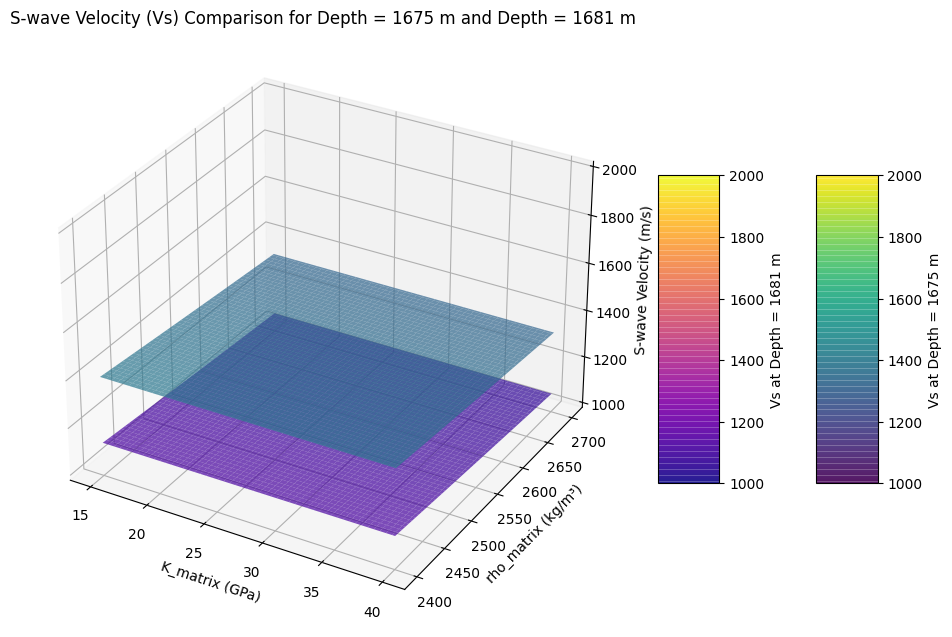

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gassmann's fluid substitution equation (kept in case you need it for Vp)
def gassmann(K_dry, K_matrix, K_fluid, porosity):
    numerator = (1 - K_dry / K_matrix)**2
    denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
    K_sat = K_dry + numerator / denominator
    return K_sat

# Set the fixed range for S-wave Velocity (Vs)
vs_min = 1000  # Set the minimum value for Vs
vs_max = 2000  # Set the maximum value for Vs

# Function to compute Vs for a given depth
def compute_vs_at_depth(specified_depth):
    # Find the index of the closest depth value in the depth_injection array
    index = np.abs(depth_injection - specified_depth).argmin()
    actual_depth = depth_injection[index]

    print(f"Specified Depth: {specified_depth} meters, Closest Depth: {actual_depth:.2f} meters at Index: {index}")

    # Create a range of K_matrix values (e.g., from 15 to 40 GPa)
    K_matrix_values = np.linspace(15, 40, num=100)  # K_matrix now in GPa

    # Create a range of rho_matrix values (e.g., from 2400 to 2700 kg/m³)
    rho_matrix_values = np.linspace(2400, 2700, num=100)

    # Create a meshgrid for K_matrix and rho_matrix
    K_matrix_mesh, rho_matrix_mesh = np.meshgrid(K_matrix_values, rho_matrix_values)

    # Recompute Vs_baseline for each combination of K_matrix and rho_matrix
    Vs_3D = np.zeros_like(K_matrix_mesh)

    # Get the values at the closest depth index
    porosity_at_fixed_depth = porosity_injection[index]
    G_dry_at_fixed_depth = G_dry[injection_zone_mask][index]  # Shear modulus is needed for Vs

    for i in range(K_matrix_values.shape[0]):
        for j in range(rho_matrix_values.shape[0]):
            # Compute baseline density
            rho_baseline = (1 - porosity_at_fixed_depth) * rho_matrix_values[j] + porosity_at_fixed_depth * rho_oil

            # Compute Vs for the fixed depth, using G_dry and rho_baseline
            Vs_3D[j, i] = np.sqrt(G_dry_at_fixed_depth / rho_baseline)

    return K_matrix_mesh, rho_matrix_mesh, Vs_3D

# Plot the merged results for two different depths for Vs
def plot_merged_vs_for_two_depths(depth1, depth2):
    # Compute Vs for both depths
    K_matrix_mesh_1, rho_matrix_mesh_1, Vs_3D_1 = compute_vs_at_depth(depth1)
    K_matrix_mesh_2, rho_matrix_mesh_2, Vs_3D_2 = compute_vs_at_depth(depth2)

    # Plot the result
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Vs for depth1 using a different color map
    surf1 = ax.plot_surface(K_matrix_mesh_1, rho_matrix_mesh_1, Vs_3D_1, cmap='viridis', alpha=0.7, vmin=vs_min, vmax=vs_max)
    
    # Plot Vs for depth2 using a different color map
    surf2 = ax.plot_surface(K_matrix_mesh_2, rho_matrix_mesh_2, Vs_3D_2, cmap='plasma', alpha=0.7, vmin=vs_min, vmax=vs_max)

    # Set labels and title
    ax.set_xlabel('K_matrix (GPa)')  # Unit in GPa
    ax.set_ylabel('rho_matrix (kg/m³)')
    ax.set_zlabel('S-wave Velocity (m/s)')
    ax.set_title(f'S-wave Velocity (Vs) Comparison for Depth = {depth1} m and Depth = {depth2} m')

    # Add colorbars for both surfaces with same range
    fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5, label=f'Vs at Depth = {depth1} m')
    fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=5, label=f'Vs at Depth = {depth2} m')

    # Set the range for S-wave Velocity (Vs) on the z-axis
    ax.set_zlim(vs_min, vs_max)

    # Show the plot
    plt.show()

# Example: Plot the merged result for two different depths for Vs
plot_merged_vs_for_two_depths(1675, 1681)


Specified Depth: 1675 meters, Closest Depth: 1675.03 meters at Index: 35
Specified Depth: 1681 meters, Closest Depth: 1681.12 meters at Index: 60


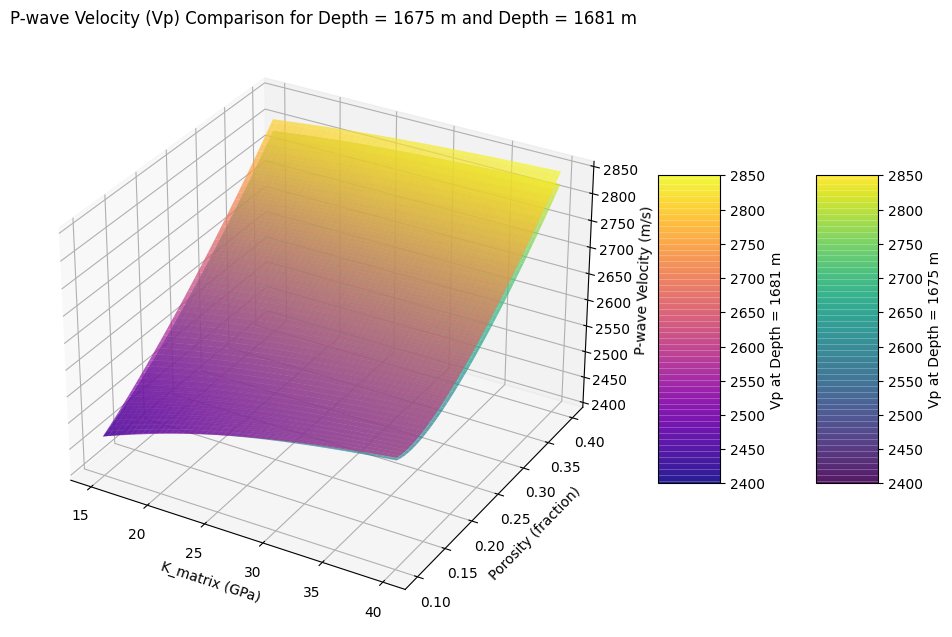

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gassmann's fluid substitution equation
def gassmann(K_dry, K_matrix, K_fluid, porosity):
    numerator = (1 - K_dry / K_matrix)**2
    denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
    K_sat = K_dry + numerator / denominator
    return K_sat

# Set the fixed range for P-wave Velocity (Vp)
vp_min = 2400  # Set the minimum value for Vp
vp_max = 2850  # Set the maximum value for Vp

# Function to compute Vp for a given depth
def compute_vp_at_depth(specified_depth):
    # Find the index of the closest depth value in the depth_injection array
    index = np.abs(depth_injection - specified_depth).argmin()
    actual_depth = depth_injection[index]

    print(f"Specified Depth: {specified_depth} meters, Closest Depth: {actual_depth:.2f} meters at Index: {index}")

    # Create a range of K_matrix values (e.g., from 15 to 40 GPa)
    K_matrix_values = np.linspace(15, 40, num=100)  # K_matrix now in GPa (no need for 10^9 factor)

    # Create a range of porosity values (e.g., from 0.1 to 0.4)
    porosity_values = np.linspace(0.1, 0.4, num=100)

    # Create a meshgrid for K_matrix and porosity
    K_matrix_mesh, porosity_mesh = np.meshgrid(K_matrix_values, porosity_values)

    # Recompute Vp_baseline for each combination of K_matrix and porosity
    Vp_3D = np.zeros_like(K_matrix_mesh)

    # Get the values at the closest depth index
    K_dry_at_fixed_depth = K_dry[injection_zone_mask][index]
    G_dry_at_fixed_depth = G_dry[injection_zone_mask][index]

    for i in range(K_matrix_values.shape[0]):
        for j in range(porosity_values.shape[0]):
            # Convert K_matrix back to Pa for calculation (multiply by 1e9)
            K_matrix_pa = K_matrix_values[i] * 1e9

            # Compute baseline density
            rho_baseline = (1 - porosity_values[j]) * rho_matrix + porosity_values[j] * rho_oil

            # Apply the Gassmann function at the closest depth
            K_baseline_temp = gassmann(K_dry_at_fixed_depth, K_matrix_pa, K_oil, porosity_values[j])

            # Compute Vp for the fixed depth, K_matrix, and porosity
            Vp_3D[j, i] = np.sqrt((K_baseline_temp + (4 / 3) * G_dry_at_fixed_depth) / rho_baseline)

    return K_matrix_mesh, porosity_mesh, Vp_3D

# Plot the merged results for two different depths
def plot_merged_vp_for_two_depths(depth1, depth2):
    # Compute Vp for both depths
    K_matrix_mesh_1, porosity_mesh_1, Vp_3D_1 = compute_vp_at_depth(depth1)
    K_matrix_mesh_2, porosity_mesh_2, Vp_3D_2 = compute_vp_at_depth(depth2)

    # Plot the result
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Vp for depth1 using a different color map
    surf1 = ax.plot_surface(K_matrix_mesh_1, porosity_mesh_1, Vp_3D_1, cmap='viridis', alpha=0.7, vmin=vp_min, vmax=vp_max)
    
    # Plot Vp for depth2 using a different color map
    surf2 = ax.plot_surface(K_matrix_mesh_2, porosity_mesh_2, Vp_3D_2, cmap='plasma', alpha=0.7, vmin=vp_min, vmax=vp_max)

    # Set labels and title
    ax.set_xlabel('K_matrix (GPa)')  # Change the unit to GPa
    ax.set_ylabel('Porosity (fraction)')
    ax.set_zlabel('P-wave Velocity (m/s)')
    ax.set_title(f'P-wave Velocity (Vp) Comparison for Depth = {depth1} m and Depth = {depth2} m')

    # Add colorbars for both surfaces with same range
    fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5, label=f'Vp at Depth = {depth1} m')
    fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=5, label=f'Vp at Depth = {depth2} m')

    # Set the range for P-wave Velocity (Vp) on the z-axis
    ax.set_zlim(vp_min, vp_max)

    # Show the plot
    plt.show()

# Example: Plot the merged result for two different depths
plot_merged_vp_for_two_depths(1675, 1681)


## Fluid parameters

Specified Depth: 1670 meters, Closest Depth: 1670.00 meters at Index: 16


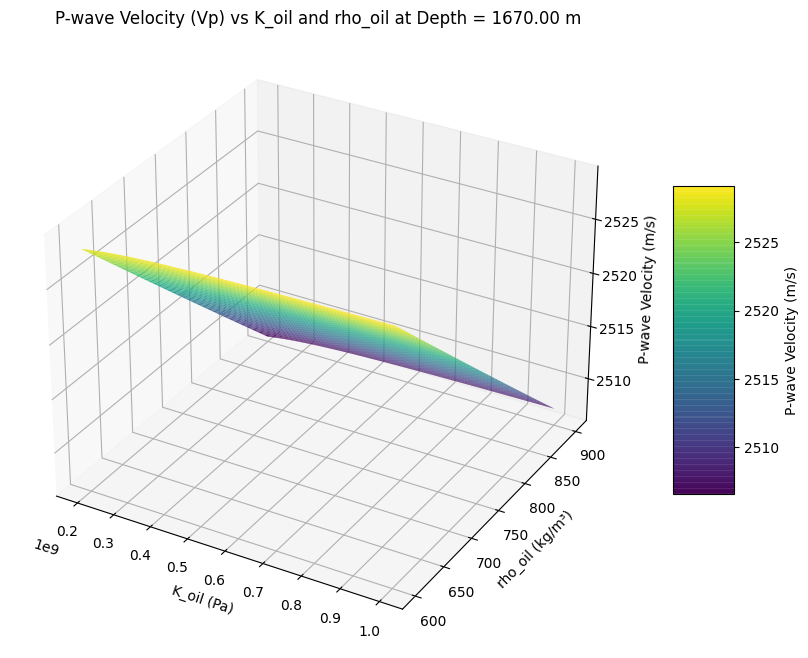

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gassmann's fluid substitution equation
def gassmann(K_dry, K_matrix, K_fluid, porosity):
    numerator = (1 - K_dry / K_matrix)**2
    denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
    K_sat = K_dry + numerator / denominator
    return K_sat

# Set constant values
K_matrix = 35e9  # Constant value for K_matrix (Pa)
rho_matrix = 2650  # Constant matrix density (kg/m³)
K_CO2 = 0.02853e9  # Constant bulk modulus of CO2 (Pa)
rho_CO2 = 478.3  # Constant density of CO2 (kg/m³)

# Specify the depth in meters
specified_depth = 1670  # Example: specify a depth in meters

# Find the index of the closest depth value in the depth_injection array
index = np.abs(depth_injection - specified_depth).argmin()
actual_depth = depth_injection[index]

print(f"Specified Depth: {specified_depth} meters, Closest Depth: {actual_depth:.2f} meters at Index: {index}")

# Create a range of K_oil values (e.g., from 0.2 to 1 GPa)
K_oil_values = np.linspace(0.2e9, 1e9, num=100)  # Vary K_oil between 0.2 and 1 GPa

# Create a range of rho_oil values (e.g., from 600 to 900 kg/m³)
rho_oil_values = np.linspace(600, 900, num=100)  # Vary rho_oil between 600 and 900 kg/m³

# Create a meshgrid for K_oil and rho_oil
K_oil_mesh, rho_oil_mesh = np.meshgrid(K_oil_values, rho_oil_values)

# Recompute Vp for each combination of K_oil and rho_oil
Vp_3D = np.zeros_like(K_oil_mesh)

# Get the values at the fixed depth index
porosity_at_fixed_depth = porosity_injection[index]
K_dry_at_fixed_depth = K_dry[injection_zone_mask][index]
G_dry_at_fixed_depth = G_dry[injection_zone_mask][index]

for i in range(K_oil_values.shape[0]):
    for j in range(rho_oil_values.shape[0]):
        # Use the given K_oil and compute mixed fluid bulk modulus (K_fluid) for oil and CO2
        K_fluid = 1 / (0.5 / K_CO2 + 0.5 / K_oil_values[i])

        # Compute baseline density using the varying rho_oil and constant rho_CO2
        rho_fluid_mixture = 0.5 * rho_CO2 + 0.5 * rho_oil_values[j]

        # Compute bulk density with mixed fluid density
        rho_baseline = (1 - porosity_at_fixed_depth) * rho_matrix + porosity_at_fixed_depth * rho_fluid_mixture

        # Apply the Gassmann function at the fixed depth
        K_sat_temp = gassmann(K_dry_at_fixed_depth, K_matrix, K_fluid, porosity_at_fixed_depth)

        # Compute Vp for the fixed depth, K_oil, and rho_oil
        Vp_3D[j, i] = np.sqrt((K_sat_temp + (4 / 3) * G_dry_at_fixed_depth) / rho_baseline)

# Plot the result
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Vp as a function of K_oil and rho_oil
surf = ax.plot_surface(K_oil_mesh, rho_oil_mesh, Vp_3D, cmap='viridis', alpha=0.9)

# Set labels and title
ax.set_xlabel('K_oil (Pa)')
ax.set_ylabel('rho_oil (kg/m³)')
ax.set_zlabel('P-wave Velocity (m/s)')
ax.set_title(f'P-wave Velocity (Vp) vs K_oil and rho_oil at Depth = {actual_depth:.2f} m')

# Add colorbar for better interpretation
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='P-wave Velocity (m/s)')

# Show the plot
plt.show()


Specified Depth: 1670 meters, Closest Depth: 1670.00 meters at Index: 16


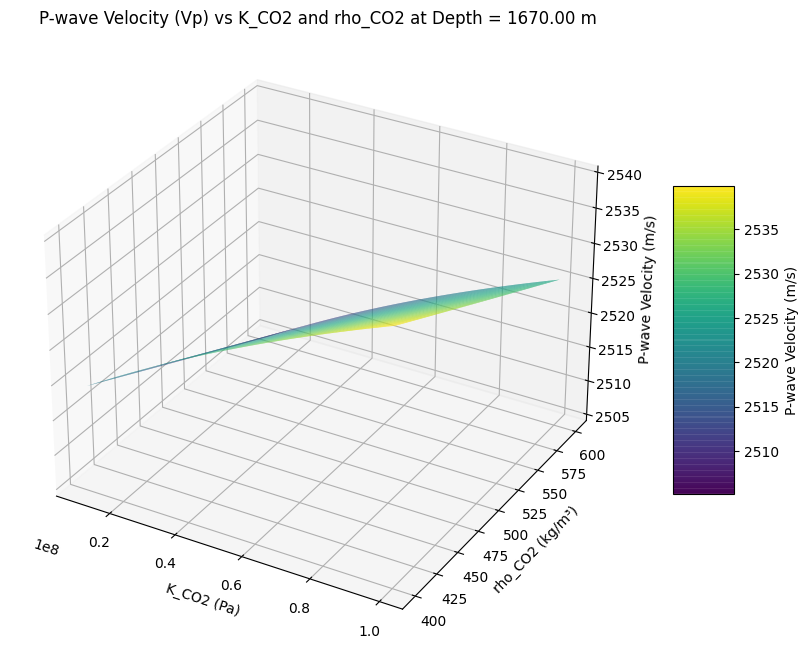

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gassmann's fluid substitution equation
def gassmann(K_dry, K_matrix, K_fluid, porosity):
    numerator = (1 - K_dry / K_matrix)**2
    denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
    K_sat = K_dry + numerator / denominator
    return K_sat

# Set constant values for oil properties
K_matrix = 25e9  # Constant value for K_matrix (Pa)
rho_matrix = 2650  # Constant matrix density (kg/m³)
K_oil = 0.3758e9  # Constant bulk modulus of oil (Pa)
rho_oil = 700  # Constant density of oil (kg/m³)

# Specify the depth in meters
specified_depth = 1670  # Example: specify a depth in meters

# Find the index of the closest depth value in the depth_injection array
index = np.abs(depth_injection - specified_depth).argmin()
actual_depth = depth_injection[index]

print(f"Specified Depth: {specified_depth} meters, Closest Depth: {actual_depth:.2f} meters at Index: {index}")

# Create a range of K_CO2 values (e.g., from 0.01 to 0.1 GPa)
K_CO2_values = np.linspace(0.01e9, 0.1e9, num=100)  # Vary K_CO2 between 0.01 and 0.1 GPa

# Create a range of rho_CO2 values (e.g., from 400 to 600 kg/m³)
rho_CO2_values = np.linspace(400, 600, num=100)  # Vary rho_CO2 between 400 and 600 kg/m³

# Create a meshgrid for K_CO2 and rho_CO2
K_CO2_mesh, rho_CO2_mesh = np.meshgrid(K_CO2_values, rho_CO2_values)

# Recompute Vp for each combination of K_CO2 and rho_CO2
Vp_3D = np.zeros_like(K_CO2_mesh)

# Get the values at the fixed depth index
porosity_at_fixed_depth = porosity_injection[index]
K_dry_at_fixed_depth = K_dry[injection_zone_mask][index]
G_dry_at_fixed_depth = G_dry[injection_zone_mask][index]

for i in range(K_CO2_values.shape[0]):
    for j in range(rho_CO2_values.shape[0]):
        # Use the given K_CO2 and compute mixed fluid bulk modulus (K_fluid) for oil and CO2
        K_fluid = 1 / (0.5 / K_CO2_values[i] + 0.5 / K_oil)

        # Compute mixed fluid density for the given rho_CO2 and constant rho_oil
        rho_fluid_mixture = 0.5 * rho_CO2_values[j] + 0.5 * rho_oil

        # Compute bulk density with mixed fluid density
        rho_baseline = (1 - porosity_at_fixed_depth) * rho_matrix + porosity_at_fixed_depth * rho_fluid_mixture

        # Apply the Gassmann function at the fixed depth
        K_sat_temp = gassmann(K_dry_at_fixed_depth, K_matrix, K_fluid, porosity_at_fixed_depth)

        # Compute Vp for the fixed depth, K_CO2, and rho_CO2
        Vp_3D[j, i] = np.sqrt((K_sat_temp + (4 / 3) * G_dry_at_fixed_depth) / rho_baseline)

# Plot the result
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Vp as a function of K_CO2 and rho_CO2
surf = ax.plot_surface(K_CO2_mesh, rho_CO2_mesh, Vp_3D, cmap='viridis', alpha=0.9)

# Set labels and title
ax.set_xlabel('K_CO2 (Pa)')
ax.set_ylabel('rho_CO2 (kg/m³)')
ax.set_zlabel('P-wave Velocity (m/s)')
ax.set_title(f'P-wave Velocity (Vp) vs K_CO2 and rho_CO2 at Depth = {actual_depth:.2f} m')

# Add colorbar for better interpretation
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='P-wave Velocity (m/s)')

# Show the plot
plt.show()
